# 03_simplest_srnn_dms

In this notebook we prepare a very simple spiking RNN that is capable of performing the Delayed Match to Sample (DMS) task. This task is the same as what is available in a [public dataset](http://dx.doi.org/10.6080/K0ZW1HVD), and is described in [Qi et al, 2011](https://academic.oup.com/cercor/article-abstract/21/12/2722/295413) and [Meyer et al, 2011](https://www.jneurosci.org/content/31/17/6266.short). There were three task types: "spatial", "feature", and "conjunction" DMS tasks. For either type, a trial began with a fixation period (1 s in duration) during which the monkeys were required to maintain gaze at the fixation point. Then a Cue was presented for 0.5 s, followed by a 1.5 s delay period, and then the Sample was presented for 0.5 s. The sample was followed by a second 1.5 s delay period before the monkey was asked to report. For a spatial DMS trial, monkeys were rewarded for choosing the Green target if the Cue and Sample matched in spatial location, else Blue. For a feature DMS trial, monkeys were rewarded for choosing the Green target if the Cue and Sample matched in shape, else Blue. For a conjunction DMS trial, both shape and location had to match to choose the Green target.

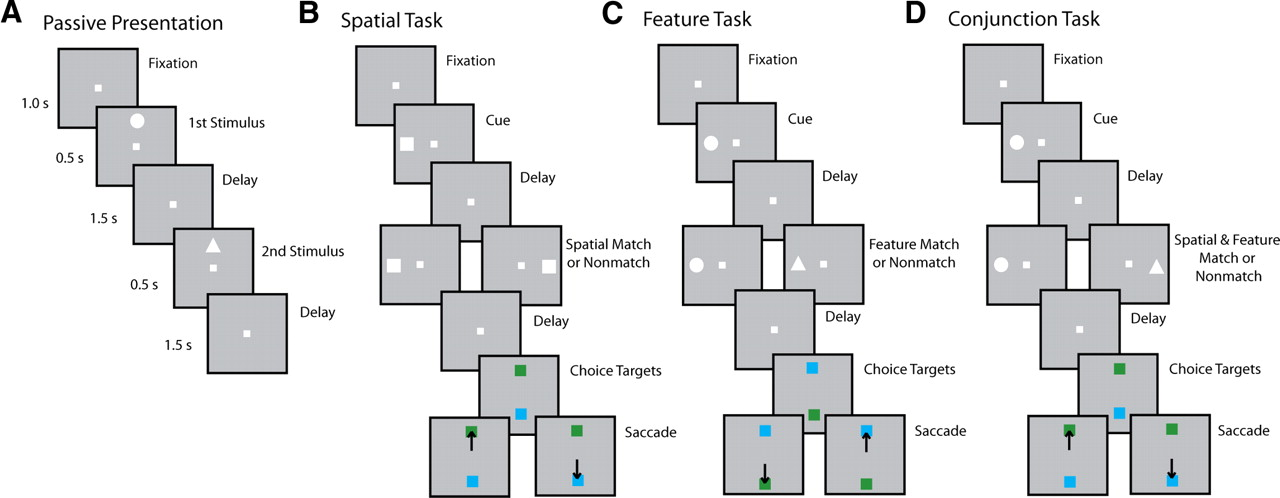

Further details:
* Spatial set involved a white 2° square that appeared randomly in one of nine locations arranged on a 3 x 3 grid with 10° spacing between stimuli.
* When the Sample was in a different location, it was typically in the 'opposite' location.
* The feature set consisted of eight white shapes that were presented at the same location on the screen. The feature stimuli fit within a 2deg square and were equalized for luminance.
* The choice targets were at the locations orthogonal to the Cue and Sample stimuli.
* The Green/Blue location varied randomly from trial to trial.

## Environment Setup

In [ ]:
#@title Run Environment Setup
try:
    # See if we are running on google.colab
    from google.colab import files
    IN_COLAB = True
    !pip install --upgrade nengo nengo-gui nbdev git+https://github.com/neuromorphs/grill-srnn-pfc.git
    !jupyter serverextension enable nengo_gui.jupyter
    # TODO: kaggle creds for downloading data 
    
except ModuleNotFoundError:
    IN_COLAB = False

%load_ext autoreload
%autoreload 2

## Task Stimulus Encoding - Spatial Only

* TODO: The following code should make its way into the shared python package.
* We are not (yet?) asking the reply to be to a green vs blue target, only to answer +1 for match or -1 for mismatch.

In [ ]:
import numpy as np

n_trials_per_condition = 5  # x 8 stim_locs x 2 match-or-mismatch
rng_seed = 1337
isi_dur = 1.0
cue_dur = 0.5
delay1_dur = 1.5
sample_dur = 0.5
delay2_dur= 1.5
response_dur = 1.0
stim_x, stim_y = 1/np.sqrt(2), 1/np.sqrt(2)

phase_durs = [isi_dur, cue_dur, delay1_dur, sample_dur, delay2_dur, response_dur]
cumulative_durs = np.cumsum(phase_durs)
trial_dur = cumulative_durs[-1]

# Fixation point acts as a hold signal. We'll just use a 1-d value: -1 for hold, +1 for go.
def hold_signal(t):
    return 1 - 2 * ((t % trial_dur) < np.sum(cumulative_durs[-2]))

# Visual stimulus location: x, y. Will be 0, 0 except during Cue and Sample
# periods. During Cue it will be set to one of 8 possible values:
cue_locs = np.array([[-stim_x,  stim_y], [0.0,  stim_y], [stim_x, stim_y],
                     [-stim_x,     0.0],                 [stim_x,    0.0],
                     [-stim_x, -stim_y], [0.0, -stim_y], [stim_x, -stim_y]])
n_locs = len(cue_locs)
trial_conds = np.tile(np.arange(n_locs * 2), n_trials_per_condition)
rng = np.random.default_rng(seed=rng_seed)
rng.shuffle(trial_conds)

def targ_signal(t):
    trial_ix = int(np.floor(t / trial_dur)) % len(trial_conds)
    t_trial = t % trial_dur
    is_cue = t_trial >= cumulative_durs[0] and t_trial < cumulative_durs[1]
    is_samp = (not is_cue) and t_trial >= cumulative_durs[2] and t_trial < cumulative_durs[3]
    if is_cue or is_samp:
        cond_ix = trial_conds[trial_ix]
        cue_loc = cue_locs[cond_ix % n_locs]
        if not is_samp:
            return cue_loc
        samp_sign = 1 - 2 * (cond_ix >= n_locs)
        return samp_sign * cue_loc
    return [0, 0]

def expected_response(t):
    trial_ix = int(np.floor(t / trial_dur)) % len(trial_conds)
    t_trial = t % trial_dur
    if t_trial >= cumulative_durs[-2]:
        cond_ix = trial_conds[trial_ix]
        return 1 - 2 * (cond_ix >= n_locs)
    return 0

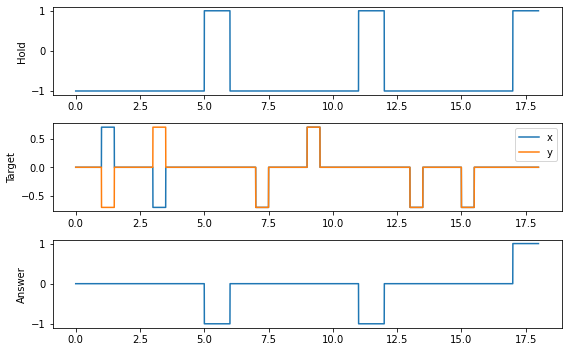

In [ ]:
import matplotlib.pyplot as plt

test_trials = 3
test_srate = 1000  # Hz
t_vec = np.arange(0, trial_dur * test_trials, 1 / test_srate)

plt.figure(figsize=(8, 5))
plt.subplot(3, 1, 1)
plt.plot(t_vec, hold_signal(t_vec))
plt.ylabel('Hold')
plt.subplot(3, 1, 2)
plt.plot(t_vec, [targ_signal(_) for _ in t_vec])
plt.ylabel('Target')
plt.legend(['x', 'y'], loc='upper right')
plt.subplot(3, 1, 3)
plt.plot(t_vec, [expected_response(_) for _ in t_vec])
plt.ylabel('Answer')
plt.tight_layout()

## Model Setup - Spatial Task Only

This model is cobbled together from Terry Stewart's ["Nengo for Neuromorphs" tutorial](https://youtu.be/Mo0cenWEz68?t=2298) and the [Nengo documentation](https://www.nengo.ai/nengo/examples/learning/learn-communication-channel.html).

In [ ]:
import nengo
import numpy as np

class DMS(nengo.Network):
    def __init__(self, tau=0.1, n_neurons=100):
        # Input Nodes
        
        # Fixation: -1 except during response period.
        self.fixation = nengo.Node(hold_signal, size_out=1, label='fixation')
        
        # Target: x,y position of target.
        # Usually 0,0, or the target location during Cue or Sample.
        self.target = nengo.Node(targ_signal, size_out=2, label='target')
        
        # Known correct answer
        self.answer = nengo.Node(expected_response, label='answer')
        
        # SNN to do the task
        # Combines fixation and target inputs.
        # Outputs 0 when fixation high, otherwise...
        # +1 when target and sample match or -1 when mismatch
        # Because the output is based on memory of Cue, then
        # memory of whether the Sample matches the Cue,
        # the ensemble must be recurrent.
        self.do_dms = nengo.Ensemble(n_neurons=n_neurons, dimensions=3, label='match', radius=2)
        nengo.Connection(self.fixation, self.do_dms[0], synapse=0.005)
        nengo.Connection(self.target, self.do_dms[1:], transform=tau, synapse=tau)
        nengo.Connection(self.do_dms, self.do_dms,
                         # function=lambda x: x,  # Anything needed here?
                         synapse=tau)
        
        # Node that does nothing
        self.output = nengo.Node(None, size_in=1, label='output')
        out_conn = nengo.Connection(self.do_dms.neurons, self.output,
                                    transform=np.zeros((1, n_neurons)),
                                    learning_rule_type=nengo.PES(learning_rate=1e-4))
        
        # error signal = output - answer
        # self.error = nengo.Node(None, size_in=1, label='error')
        self.error = nengo.Ensemble(100, dimensions=1, label='error')
        nengo.Connection(self.output, self.error)
        nengo.Connection(self.answer, self.error, transform=-1)
        nengo.Connection(self.error, out_conn.learning_rule)

In [ ]:
from nengo_gui.ipython import IPythonViz

with nengo.Network() as inet:
    inet.dms = DMS(tau=0.2, n_neurons=500)
IPythonViz(inet)

In [ ]:
def suppress_error(t):
    return 2.0 if t >= 80 * trial_dur else 0.0

def test_dms(net, sim_trials=160):
    sim_time = sim_trials * trial_dur
    with net:
        net.dms = DMS(tau=0.3, n_neurons=1000)
        
        inhib = nengo.Node(suppress_error)
        nengo.Connection(inhib, net.dms.error.neurons, transform=[[-1]] * net.dms.error.n_neurons)
        
        probes = {
            'fix': nengo.Probe(net.dms.fixation),
            'targ': nengo.Probe(net.dms.target),
            'answer': nengo.Probe(net.dms.answer),
            'dms': nengo.Probe(net.dms.do_dms),
            'out': nengo.Probe(net.dms.output),
            'error': nengo.Probe(net.dms.error)
        }
    
    with nengo.Simulator(net) as sim:
        sim.run(sim_time)
    return sim, probes
    
net = nengo.Network()
sim, probes = test_dms(net)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

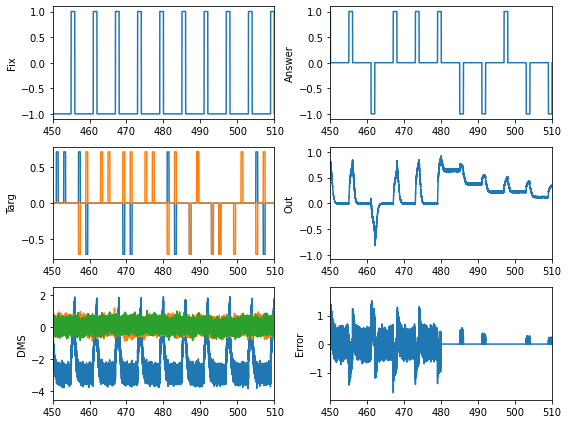

In [ ]:
t = sim.trange()
xrange = [trial_dur*75, trial_dur*85]

plt.figure(figsize=(8, 6))

plt.subplot(3, 2, 1)
plt.plot(t, sim.data[probes['fix']])
plt.xlim(xrange)
plt.ylabel('Fix')

plt.subplot(3, 2, 3)
plt.plot(t, sim.data[probes['targ']])
plt.xlim(xrange)
plt.ylabel('Targ')

plt.subplot(3, 2, 5)
plt.plot(t, sim.data[probes['dms']])
plt.xlim(xrange)
plt.ylabel('DMS')

plt.subplot(3, 2, 2)
plt.plot(t, sim.data[probes['answer']])
plt.xlim(xrange)
plt.ylabel('Answer')

plt.subplot(3, 2, 4)
plt.plot(t, sim.data[probes['out']])
plt.xlim(xrange)
plt.ylabel('Out')

plt.subplot(3, 2, 6)
plt.plot(t, sim.data[probes['error']])
plt.xlim(xrange)
plt.ylabel('Error')

plt.tight_layout()